# Jena Climate

Jena Climate is weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

# Dataset

### Feature Description Table

| Features | Format | Description |
|-----------|---------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Date Time | 01.01.2009 00:10:00 | Date-time reference |
| p (mbar) | 996.52 | The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars. |
| T (degC) | -8.02 | Temperature in Celsius |
| Tpot (K) | 265.4 | Temperature in Kelvin |
| Tdew (degC) | -8.9 | Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses. |
| rh (%) | 93.3 | Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects. |
| VPmax (mbar) | 3.33 | Saturation vapor pressure |
| VPact (mbar) | 3.11 | Vapor pressure |
| VPdef (mbar) | 0.22 | Vapor pressure deficit |
| sh (g/kg) | 1.94 | Specific humidity |
| H2OC (mmol/mol) | 3.12 | Water vapor concentration |
| rho (g/m^3) | 1307.75 | Airtight |
| wv (m/s) | 1.03 | Wind speed |
| max. wv (m/s) | 1.75 | Maximum wind speed |
| wd (deg) | 152.3 | Wind direction in degrees |


In [4]:
url1 = ('https://raw.githubusercontent.com/gilbutITbook/006975/refs/heads/master/datasets/jena_climate/jena_climate_2009_2016.csv')

jena = pd.read_csv(url1, sep=',')

jena.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
jena.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [6]:
# Ensure the column 'Date Time' is in datetime format with dayfirst=True
jena['Date Time'] = pd.to_datetime(jena['Date Time'], dayfirst=True, errors='coerce')

# Drop rows where the 'Date Time' could not be converted
jena.dropna(subset=['Date Time'], inplace=True)

# Set 'Date Time' as the index of the dataframe
jena.set_index('Date Time', inplace=True)

# Display the first few rows to confirm
jena.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [7]:
# Group data by day (removing the hour part) and calculate the mean
jena_daily = jena.resample('D').mean()

# Display the result
jena_daily.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01,999.145594,-6.810629,266.414545,-8.015594,91.086014,3.691119,3.355524,0.335315,2.091049,3.357832,1305.178252,0.778601,1.378252,181.863077
2009-01-02,999.600625,-3.728194,269.463194,-4.824861,92.086806,4.640069,4.267292,0.373056,2.659792,4.268750,1290.353194,1.419514,2.227361,125.072014
2009-01-03,998.548611,-5.271736,268.002292,-9.015833,76.458056,4.184792,3.107708,1.077014,1.937778,3.111944,1297.117014,1.250903,2.065069,190.383333
2009-01-04,988.510694,-1.375208,272.685347,-2.897014,89.417361,5.524306,4.938958,0.584861,3.114028,4.997014,1264.634514,1.720417,3.564861,213.069861
2009-01-05,990.405694,-4.867153,269.039306,-6.797292,86.260417,4.362708,3.806736,0.555625,2.397014,3.847778,1284.372778,3.800278,5.940000,118.287361


In [8]:
jena_daily.tail()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2016-12-28,1013.542986,4.887153,276.979444,2.408542,84.070833,8.672500,7.269583,1.403264,4.473264,7.171875,1266.425556,2.558194,4.726597,254.427708
2016-12-29,1013.957569,2.676250,274.744583,1.246458,90.384722,7.447569,6.705833,0.741250,4.123889,6.613542,1277.391528,0.837986,1.394028,196.642639
2016-12-30,1010.460278,-1.706597,270.647361,-2.727292,92.927083,5.465764,5.048542,0.416458,3.113889,4.996875,1294.402639,1.138125,1.839306,201.359028
2016-12-31,1004.476181,-2.492500,270.323681,-6.548472,74.360694,5.226111,3.765069,1.460972,2.335069,3.749444,1291.183472,0.803403,1.453542,194.592153
2017-01-01,999.820000,-4.820000,268.360000,-8.420000,75.700000,4.270000,3.230000,1.040000,2.010000,3.230000,1296.380000,1.230000,1.960000,184.900000


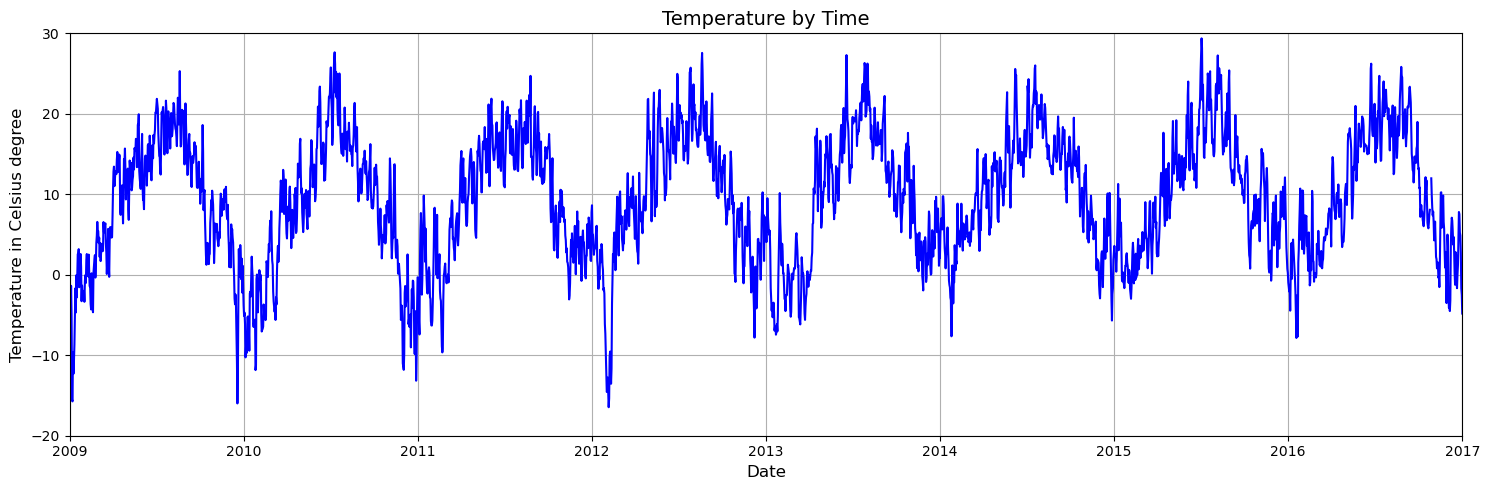

In [9]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Plot traffic volume using line plot
ax.plot(jena_daily.index, 
        jena_daily['T (degC)'],
        color='blue')    

# Formatting
ax.set_xlabel('Date', fontsize=12)  
ax.set_ylabel('Temperature in Celsius degree', fontsize=12)  
ax.set_title('Temperature by Time', fontsize=14)  

# Set XY-limits
ax.set_ylim(-20, 30)
ax.set_xlim(pd.to_datetime('2009-01-01'), pd.to_datetime('2017-01-01'))
ax.grid(True) 

# Show the plot
plt.tight_layout()
plt.show();

In [10]:
df = jena_daily[jena_daily.index > "2013-12-31"]

In [11]:
# Split the data
cutoff = pd.to_datetime("2016-10-01")

train = df[df.index < cutoff]
test = df[df.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (1004, 14)
Test shape: (93, 14)

              p (mbar)   T (degC)    Tpot (K)  Tdew (degC)     rh (%)  \
Date Time                                                               
2016-09-26  995.515972  13.911458  287.440000    11.015833  83.030556   
2016-09-27  999.012014  15.679375  288.921319    12.181458  81.117569   
2016-09-28  998.315000  15.981528  289.282292    10.834236  73.837292   
2016-09-29  991.357639  18.990625  292.879861    11.307708  62.285069   
2016-09-30  988.252986  14.290278  288.423333    11.087361  81.792014   

            VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                         
2016-09-26     16.161944     13.245278      2.916389   8.317292   
2016-09-27     18.160694     14.222361      3.938264   8.902847   
2016-09-28     18.753542     13.014306      5.738958   8.149097   
2016-09-29     22.420903     13.419375      9.001389   8.464097   
2016-09-30     16.423681     13.229097  

In [12]:
tem_series = train['T (degC)']

len(tem_series)

1004

In [13]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  


d = determine_nonseasonal_d(tem_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -2.1444, p-value = 0.2270
d = 1 | ADF Statistic = -12.2437, p-value = 0.0000

Non-seasonal differencing term (d): 1


In [14]:
def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [4, 7, 12, 24, 30, 52, 365]:

    D = determine_seasonal_D(tem_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 12: 0
Seasonal differencing term (D) for 24: 0
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 0
Seasonal differencing term (D) for 365: 1


```Python
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs, nsdiffs


# Function to determine d using the ADF test
def calculate_d(series):
    return ndiffs(series, test='adf')

# Function to determine D using the CH (Canova-Hansen) test
def calculate_D(series, period=365):
    return nsdiffs(series, m=period, test='ch')

# Load the time series data
cutoffm = pd.to_datetime("2016-01-01")
trainm = jena_daily[jena_daily.index < cutoffm]
series = trainm['T (degC)']

# Set the size of the rolling window (1000 rows)
window_size = 1000
d_values = []  # List to store d values for each window
D_values = []  # List to store D values for each window

# Apply the rolling window analysis
for start in range(0, len(series) - window_size):
    window = series[start:start + window_size]  # Define the rolling window
    d = calculate_d(window)                     # Calculate d using the ADF test
    D = calculate_D(window)                     # Calculate D using the CH test
    d_values.append(d)                          # Store the d value for the window
    D_values.append(D)                          # Store the D value for the window

# Generate the plot to visualize the stability of d and D values
plt.figure(figsize=(12, 6))                   
plt.plot(d_values, label='d (ADF Test)', color='blue')    
plt.plot(D_values, label='D (CH Test)', color='red')      
plt.title('d and D Values in Rolling Windows (1000 Rows)') 
plt.xlabel('Window Index')                    
plt.ylabel('d or D Value')                    
plt.legend()                                 
plt.grid(True)                                
plt.show()  
```

In [15]:
def detect_seasonal(series):

    # Apply Fourier Transform
    fourier = np.fft.fft(series - np.mean(series))
    frequencies = np.fft.fftfreq(len(series))

    # Identify the most significant frequency (ignoring the 0 frequency)
    positive_freqs = frequencies[np.where(frequencies > 0)]
    significant_freq = positive_freqs[np.argmax(np.abs(fourier[1:len(positive_freqs)+1]))]

    # Calculate the seasonal period (S)
    S = int(1 / significant_freq)

    return print(f"Detected Seasonal Period: S = {S}")

detect_seasonal(tem_series)

Detected Seasonal Period: S = 334


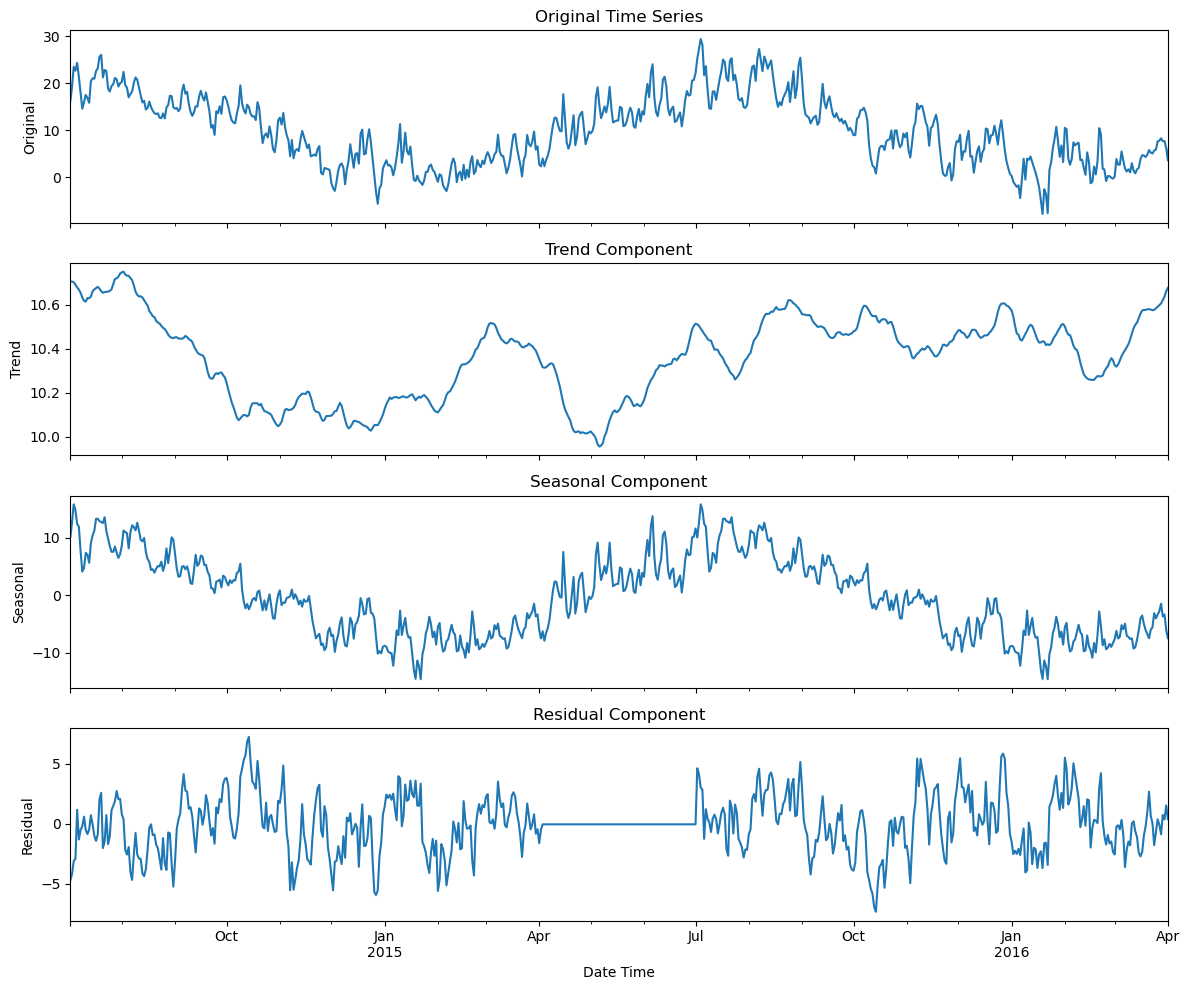

In [16]:
result = seasonal_decompose(tem_series, model='aditive', period=365)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Original')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

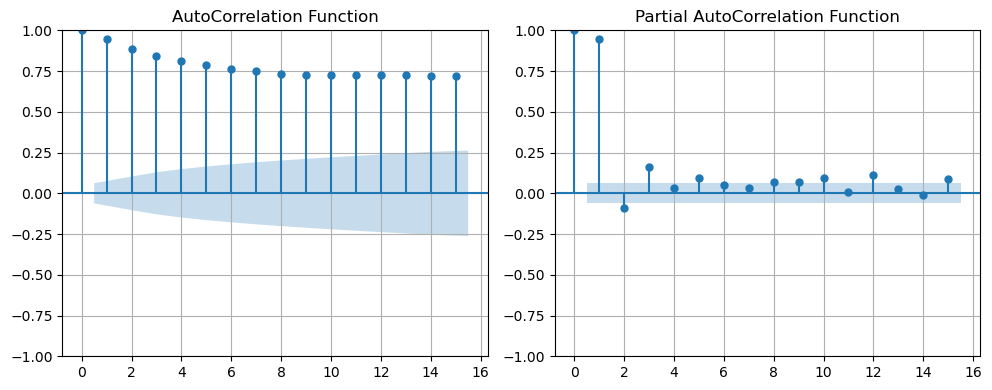

In [17]:
def acf_and_pacf(series, lagsn=15):

    # Create a 1x2 grid for subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

    # Plot AutoCorrelation Function
    plot_acf(series, ax=axes[0], lags=lagsn)
    axes[0].set_title("AutoCorrelation Function", fontsize=12)
    axes[0].grid(True)

    # Plot Partial Autocorrelation Function
    plot_pacf(series, ax=axes[1], lags=lagsn)
    axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

acf_and_pacf(tem_series, lagsn=15)

```Python
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]       # Generate Cartesian product of input lists
    return combo                                         # Return the list of combinations


def find_best(series, d=0, D=0, S=12):

    P_ns, Q_ns = [0, 1, 2], [0, 1, 2]                    # Define search ranges for non-seasonal parameters (p, q)
    P_s, Q_s = [0, 1, 2], [0, 1, 2]                      # Define search ranges for seasonal parameters (P, Q)


    total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
    print(f'Total number of models: {total}')

    vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

    score = {}                                           # Dictionary to store model evaluation metrics

    for i, (p, d, q, P, D, Q) in enumerate(vals):        # Iterate over all parameter combinations
    
        if i % 1 == 0:                                   # Print progress every 15 models
            print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

        m = SARIMAX(series,                              # Define SARIMA model with current parameter set
                    order=(p,d,q), 
                    seasonal_order=(P, D, Q, S),   
                    enforce_stationarity=False)          # Allow non-stationary models for broader search

        res = m.fit(disp=0, low_memory=True)             # Fit the model silently

        score[i] = {                                     # Store model results and evaluation metrics
            'non-seasonal order': (p, d, q),      
            'seasonal order': (P, D, Q),
            'AIC': res.aic,                              # Akaike Information Criterion
        }
        
    print("\nBest models by AIC:")
    best_models = pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()
    print(best_models)


find_best(series=tem_series, d=1, D=1, S=365)
```

In [18]:
model_212 = SARIMAX(tem_series, 
                    order=(2, 1, 2), 
                    seasonal_order=(1, 1, 0, 365), 
                    enforce_stationarity=False)

print("Number of States:", model_212.ssm.k_states)

Number of States: 733


In [19]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_212 = SARIMAX(tem_series,                     # Time series data
                    order=(2, 1, 2),                # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 1, 0, 365),  # Seasonal order (P,D,Q,S)  #<==== (1, 1, 0, 365) is standard for S = 365
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_212 = model_212.fit(method='powell',      # Optimization method (efficient for large models)
                              maxiter=500,          # Set the maximum number of iterations to 500
                              disp=False,           # Disable verbose output during optimization
                              low_memory=True)      # Enable low memory mode

# Display summary of the model
print(model_fit_212.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             T (degC)   No. Observations:                 1004
Model:             SARIMAX(2, 1, 2)x(1, 1, [], 365)   Log Likelihood                -649.743
Date:                              Tue, 20 May 2025   AIC                           1311.485
Time:                                      12:45:42   BIC                           1333.098
Sample:                                  01-01-2014   HQIC                          1320.163
                                       - 09-30-2016                                         
Covariance Type:                             approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5234      0.202      2.592      0.010       0.128       0.919
ar.L2          0.16

In [20]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_212)

ar.L2 coefficient: 0.1645
ar.L2 95% CI: (-0.1859, 0.5149)
ar.L2 p-value: 0.3576
ar.L2 is statistically IRRELEVANT in the model.



In [21]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_112 = SARIMAX(tem_series,                     # Time series data
                    order=(1, 1, 2),                # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 1, 0, 365),  # Seasonal order (P,D,Q,S)  #<==== (1, 1, 0, 365) is standard for S = 365
                    enforce_stationarity=False)     # Allow non-stationary behavior
                    
# Fit the model
model_fit_112 = model_112.fit(method='powell',      # Optimization method (efficient for large models)
                              maxiter=500,          # Set the maximum number of iterations to 500
                              disp=False,           # Disable verbose output during optimization
                              low_memory=True)      # Enable low memory mode

# Display summary of the model
print(model_fit_112.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             T (degC)   No. Observations:                 1004
Model:             SARIMAX(1, 1, 2)x(1, 1, [], 365)   Log Likelihood                -651.648
Date:                              Tue, 20 May 2025   AIC                           1313.297
Time:                                      14:09:00   BIC                           1331.326
Sample:                                  01-01-2014   HQIC                          1320.535
                                       - 09-30-2016                                         
Covariance Type:                             approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6895      0.057     12.001      0.000       0.577       0.802
ma.L1         -0.67

In [22]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_112)

All variables are statistically relevant.


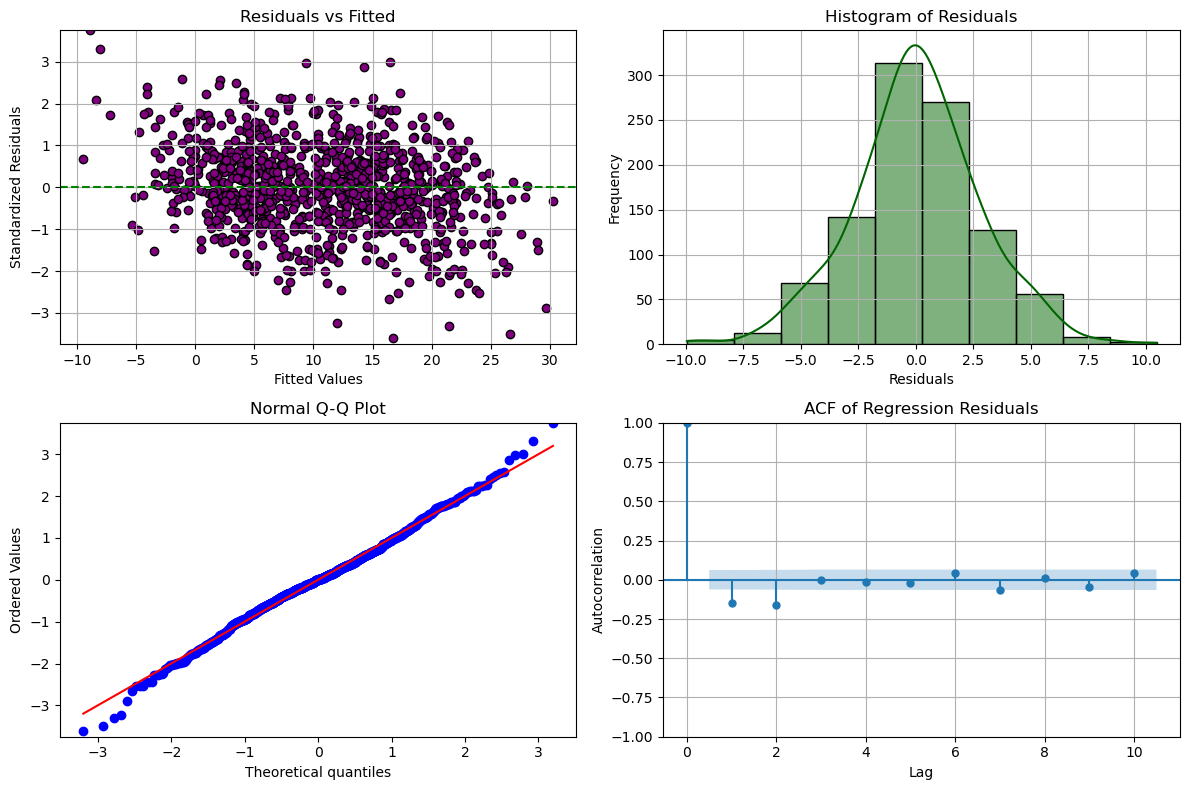

In [23]:
import scipy.stats as stats

# Diagnostic plots for the model, including residuals and other model checks
#model_fit_112.plot_diagnostics(figsize=(10, 8))
#plt.tight_layout()
#plt.show();

# Extract the residuals (errors) from the fitted model
residuals = model_fit_112.resid  

# Extract fitted values from the fitted model
fitted = model_fit_112.fittedvalues

# Standardize Residuals
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Standardized Residuals vs Fitted
axes[0, 0].scatter(fitted, standardized_residuals, color='purple', edgecolor='k')
axes[0, 0].axhline(y=0, color='green', linestyle='--')          
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Standardized Residuals')
axes[0, 0].set_title('Residuals vs Fitted')
max_resid = max(abs(standardized_residuals))
axes[0, 0].set_ylim(-max_resid, max_resid)
axes[0, 0].grid(True)

# 2. Histogram of Residuals
sns.histplot(residuals, bins=10, edgecolor='black', color='darkgreen', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# 3. Q-Q Plot
stats.probplot(standardized_residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot')
axes[1, 0].set_ylim(-max_resid, max_resid)
axes[1, 0].grid(False)

# 4. Correlogram (ACF)
plot_acf(residuals, lags=10, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Regression Residuals')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].grid(True)

# Show layout
plt.tight_layout()
plt.show();

In [24]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_112.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,21.983835,2.749565e-06
2,48.208687,3.401078e-11
3,48.209087,1.922108e-10
4,48.480385,7.493951e-10
5,48.879899,2.348288e-09
6,50.702958,3.397797e-09
7,55.011725,1.482953e-09
8,55.195885,4.044326e-09
9,57.396217,4.243253e-09
10,59.486653,4.532115e-09


In [25]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 2.2921
Conclusion: No significant autocorrelation.


In [26]:
# Forecast the next Time points
forecast_S = model_fit_112.get_forecast(steps=test.shape[0])

# Extract predicted mean and confidence intervals
forecast_mean_S = forecast_S.predicted_mean
conf_int_S = forecast_S.conf_int()        

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_S.values                 # Forecast mean

test['Error S'] = test['Forecast S'] - test['T (degC)']

test['Lower 95% CI S'] = conf_int_S.iloc[:, 0].values       # Lower bound
test['Upper 95% CI S'] = conf_int_S.iloc[:, 1].values       # Upper bound

# Show the updated test DataFrame
test.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Forecast S,Error S,Lower 95% CI S,Upper 95% CI S
Date Time,,,,,,,,,,,,,,,,,,
2016-10-01,984.673472,13.099653,287.528750,11.646319,91.473611,15.329444,13.784583,1.545069,8.756042,14.002083,1192.087986,1.504653,2.442083,193.072639,12.240732,-0.858921,NaN,NaN
2016-10-02,986.810694,13.239861,287.489514,7.826458,71.122361,15.357222,10.695625,4.661250,6.770556,10.839931,1195.444861,2.820417,4.273125,211.470139,13.081520,-0.158341,NaN,NaN
2016-10-03,994.944792,10.732361,284.305139,8.464722,86.010417,12.915972,11.099444,1.816667,6.967500,11.154514,1215.739028,2.208403,3.836944,228.039097,12.690698,1.958337,NaN,NaN
2016-10-04,1003.935694,10.834514,283.675903,6.941944,78.451944,13.038889,10.122986,2.915278,6.298819,10.086597,1226.799653,3.470556,5.369236,82.929653,13.196040,2.361526,NaN,NaN
2016-10-05,1003.269583,7.198542,280.098056,4.639028,83.997778,10.210972,8.535278,1.676944,5.309792,8.508819,1242.650556,2.328056,4.314236,88.685764,13.222189,6.023647,NaN,NaN


In [27]:
conf_int_S

,lower T (degC),upper T (degC)
2016-10-01,NaN,NaN
2016-10-02,NaN,NaN
2016-10-03,NaN,NaN
2016-10-04,NaN,NaN
2016-10-05,NaN,NaN
...,...,...
2016-12-28,NaN,NaN
2016-12-29,NaN,NaN
2016-12-30,NaN,NaN
2016-12-31,NaN,NaN


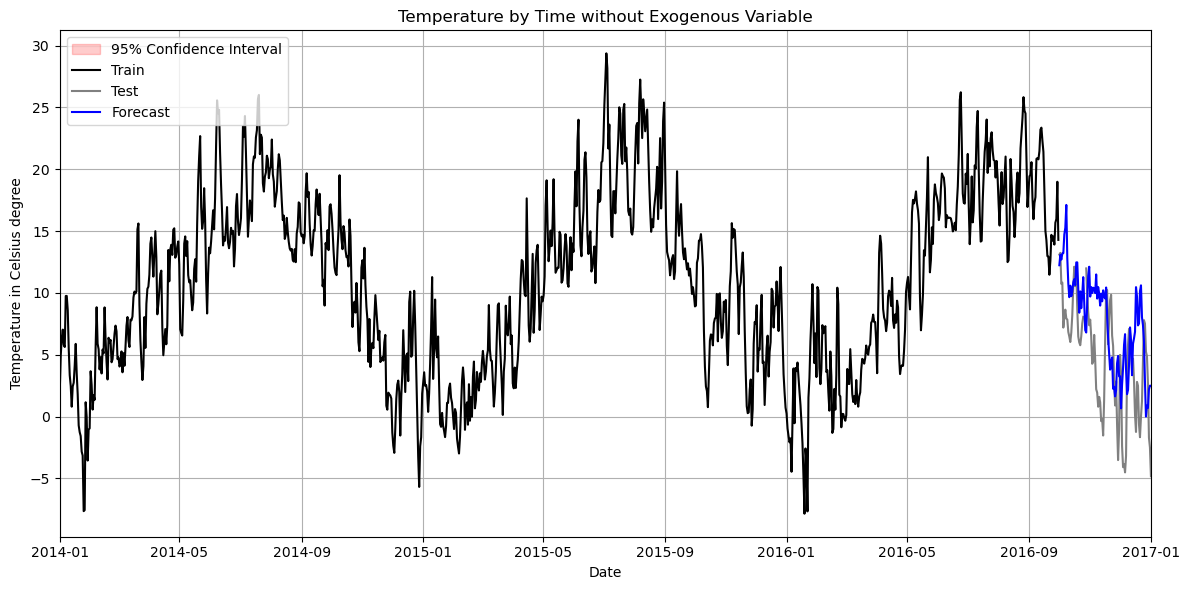

In [28]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['T (degC)'], label='Train', color='black')       # Train
plt.plot(test.index, test['T (degC)'], label='Test', color='gray')           # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Temperature by Time without Exogenous Variable')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature in Celsius degree')  
plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2017-01-01'))

# Set y-axis to avoid scientific notation
#plt.ticklabel_format(axis='y', style='plain')  

plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

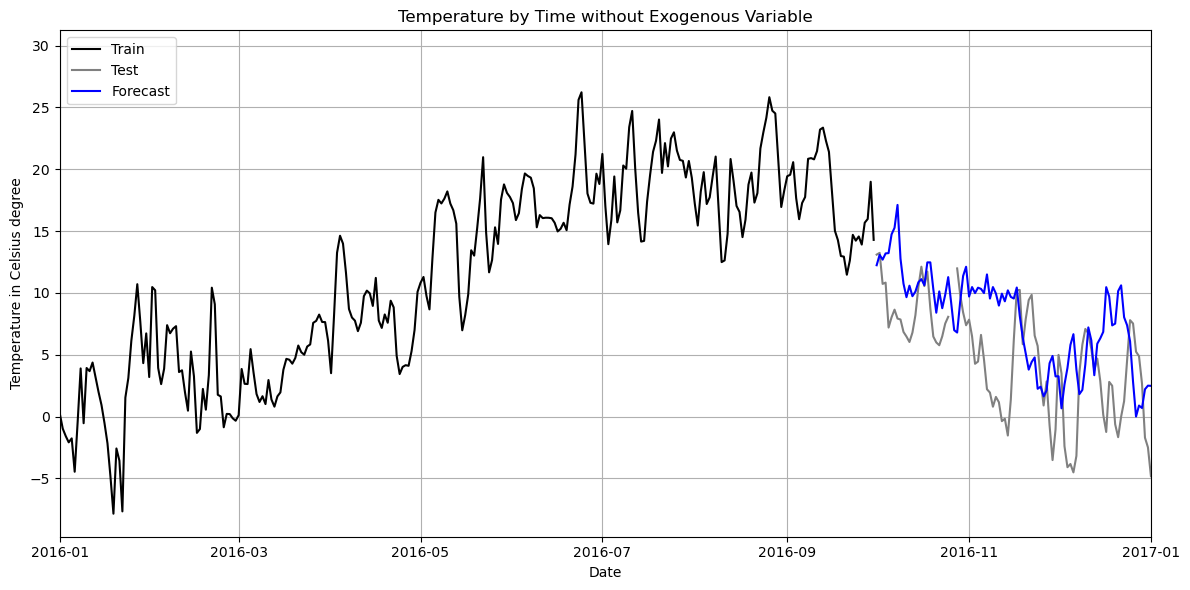

In [29]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(train.index, train['T (degC)'], label='Train', color='black')       # Train
plt.plot(test.index, test['T (degC)'], label='Test', color='gray')           # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Temperature by Time without Exogenous Variable')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature in Celsius degree')  
plt.xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2017-01-01'))

# Set y-axis to avoid scientific notation
#plt.ticklabel_format(axis='y', style='plain')  

plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

# SARIMAX Model with Exogenous Variables

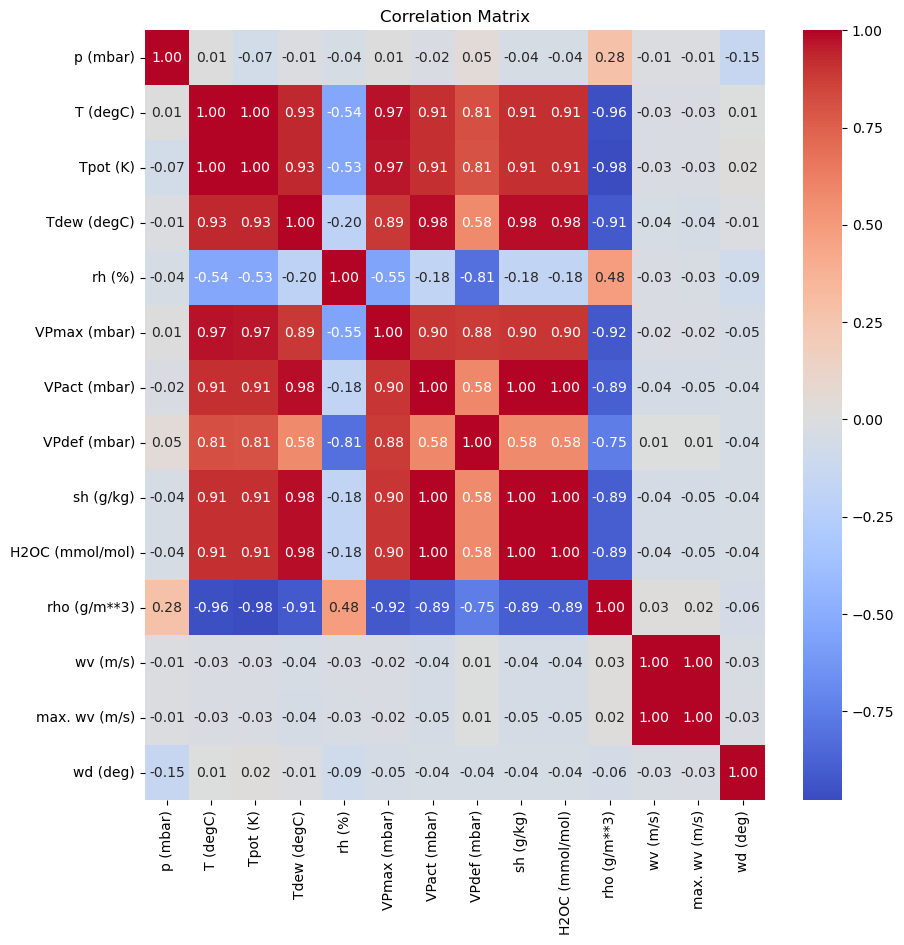

In [30]:
# Compute correlation matrix
c_matrix = train.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(c_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Dataset

### Feature Description Table

| Features | Format | Description |
|-----------|---------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Date Time | 01.01.2009 00:10:00 | Date-time reference |
| p (mbar) | 996.52 | The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars. |
| T (degC) | -8.02 | Temperature in Celsius |
| Tpot (K) | 265.4 | Temperature in Kelvin |
| Tdew (degC) | -8.9 | Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses. |
| rh (%) | 93.3 | Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects. |
| VPmax (mbar) | 3.33 | Saturation vapor pressure |
| VPact (mbar) | 3.11 | Vapor pressure |
| VPdef (mbar) | 0.22 | Vapor pressure deficit |
| sh (g/kg) | 1.94 | Specific humidity |
| H2OC (mmol/mol) | 3.12 | Water vapor concentration |
| rho (g/m^3) | 1307.75 | Airtight |
| wv (m/s) | 1.03 | Wind speed |
| max. wv (m/s) | 1.75 | Maximum wind speed |
| wd (deg) | 152.3 | Wind direction in degrees |


In [31]:
# Identify columns where the second row value is >= 0.7 or <= -0.7
selected_columns = c_matrix.columns[np.logical_or(c_matrix.iloc[1] >= 0.70, 
                                                  c_matrix.iloc[1] <= -0.70)]

# Convert to list and remove target series
filtered_columns = [col for col in selected_columns if col != 'T (degC)']

# Show the result
print(filtered_columns)

['Tpot (K)', 'Tdew (degC)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)']


In [32]:
# Create candidates dataframe
candidates = train[filtered_columns]

# Drop columns
candidates = candidates.drop(columns=['Tpot (K)', 'Tdew (degC)',])

# Compute correlation matrix
corr_candidates = candidates.corr()

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = corr_candidates.columns
vif_data["VIF"] = [round(variance_inflation_factor(corr_candidates.values, i), 2) for i in range(len(corr_candidates.columns))]

# Define VIF interpretation rules
conditions = [
    (vif_data["VIF"] < 5),
    (vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10),
    (vif_data["VIF"] > 10)
]
choices = [
    "Not Multicollinearity",
    "Moderate Multicollinearity",
    "High Multicollinearity"
]

# Add interpretation column
vif_data["Interpretation"] = np.select(conditions, choices, default="Undefined")

# Make 'Feature' as Index
vif_data.set_index('Feature', inplace=True)

# Display VIF results
print(vif_data)
print()

# Compute and display correlation matrix
corr = corr_candidates.corr().round(2)
print(f'Correlation:\n{corr}')

                          VIF          Interpretation
Feature                                              
VPmax (mbar)              inf  High Multicollinearity
VPact (mbar)              inf  High Multicollinearity
VPdef (mbar)              inf  High Multicollinearity
sh (g/kg)        1.067204e+13  High Multicollinearity
H2OC (mmol/mol)  1.086514e+13  High Multicollinearity
rho (g/m**3)     1.879020e+08  High Multicollinearity

Correlation:
                 VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
VPmax (mbar)             1.00          0.98          0.96       0.98   
VPact (mbar)             0.98          1.00          0.88       1.00   
VPdef (mbar)             0.96          0.88          1.00       0.88   
sh (g/kg)                0.98          1.00          0.88       1.00   
H2OC (mmol/mol)          0.98          1.00          0.88       1.00   
rho (g/m**3)            -1.00         -0.99         -0.94      -0.99   

                 H2OC (mmol/mol)  rho (g/m**3)  


In [34]:
exog_data = train[['rho (g/m**3)']]   # Multiple column selection
endog_data = train['T (degC)']        # Target variable selection

In [35]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(1, 1, 2),               
                  seasonal_order=(1, 1, 0, 365),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit(method='powell',   # Optimization method (efficient for large models)
                          maxiter=500,       # Set the maximum number of iterations to 500
                          disp=False,        # Disable verbose output during optimization
                          low_memory=True)   # Enable low memory mode

# Display model summary
print(model_fit_M.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             T (degC)   No. Observations:                 1004
Model:             SARIMAX(1, 1, 2)x(1, 1, [], 365)   Log Likelihood                -427.501
Date:                              Tue, 20 May 2025   AIC                            867.003
Time:                                      15:38:35   BIC                            888.638
Sample:                                  01-01-2014   HQIC                           875.688
                                       - 09-30-2016                                         
Covariance Type:                             approx                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
rho (g/m**3)    -0.1587      0.005    -34.125      0.000      -0.168      -0.150
ar.L1        

In [36]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_M)

All variables are statistically relevant.


In [37]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_M.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,72.092817,2.053098e-17
2,74.937863,5.338875e-17
3,75.588764,2.709646e-16
4,75.966292,1.244532e-15
5,76.181955,5.270879e-15
6,76.185925,2.187196e-14
7,76.186139,8.233798e-14
8,76.292366,2.717091e-13
9,76.292687,8.776040e-13
10,76.301052,2.654191e-12


In [38]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.8618
Conclusion: No significant autocorrelation.


In [40]:
exog_test_M = test[['rho (g/m**3)']] 

print(exog_test_M.isna().sum())  # Show how many NaNs are in the exog
print(exog_test_M[exog_test_M.isna().any(axis=1)])  # Show rows with NaNs

rho (g/m**3)    2
dtype: int64
            rho (g/m**3)
Date Time               
2016-10-26           NaN
2016-10-27           NaN


In [41]:
# Fix the exogenous variable by filling NaNs
exog_test_M = test[['rho (g/m**3)']].copy()
exog_test_M = test[['rho (g/m**3)']].interpolate()

# Confirm fix
print(exog_test_M.isna().sum())  # Should be 0 now

rho (g/m**3)    0
dtype: int64


In [42]:
# Forecast the next Time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=test.shape[0], exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast M'] = forecast_mean_M.values
test['Error M'] = test['Forecast M'] - test['T (degC)']
test['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,max. wv (m/s),wd (deg),Forecast S,Error S,Lower 95% CI S,Upper 95% CI S,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
Date Time,,,,,,,,,,,,,,,,,,,,,
2016-10-01,984.673472,13.099653,287.528750,11.646319,91.473611,15.329444,13.784583,1.545069,8.756042,14.002083,...,2.442083,193.072639,12.240732,-0.858921,NaN,NaN,13.533425,0.433772,NaN,NaN
2016-10-02,986.810694,13.239861,287.489514,7.826458,71.122361,15.357222,10.695625,4.661250,6.770556,10.839931,...,4.273125,211.470139,13.081520,-0.158341,NaN,NaN,12.708052,-0.531809,NaN,NaN
2016-10-03,994.944792,10.732361,284.305139,8.464722,86.010417,12.915972,11.099444,1.816667,6.967500,11.154514,...,3.836944,228.039097,12.690698,1.958337,NaN,NaN,9.167950,-1.564411,NaN,NaN
2016-10-04,1003.935694,10.834514,283.675903,6.941944,78.451944,13.038889,10.122986,2.915278,6.298819,10.086597,...,5.369236,82.929653,13.196040,2.361526,NaN,NaN,7.572858,-3.261655,NaN,NaN
2016-10-05,1003.269583,7.198542,280.098056,4.639028,83.997778,10.210972,8.535278,1.676944,5.309792,8.508819,...,4.314236,88.685764,13.222189,6.023647,NaN,NaN,4.245605,-2.952937,NaN,NaN


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Drop rows where either Forecast or True value is NaN
mask_s = test[['T (degC)', 'Forecast S']].dropna()
mask_m = test[['T (degC)', 'Forecast M']].dropna()

# Metrics for Forecast without Exo
mae_s = mean_absolute_error(mask_s['T (degC)'], mask_s['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(mask_s['T (degC)'], mask_s['Forecast S']))
mape_s = mean_absolute_percentage_error(mask_s['T (degC)'], mask_s['Forecast S']) * 100

# Metrics for Forecast with Exo
mae_m = mean_absolute_error(mask_m['T (degC)'], mask_m['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(mask_m['T (degC)'], mask_m['Forecast M']))
mape_m = mean_absolute_percentage_error(mask_m['T (degC)'], mask_m['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {'MAE': mae_s, 
             'RMSE': rmse_s, 
             #'MAPE': mape_s
            }

metrics_M = {'MAE': mae_m, 
             'RMSE': rmse_m, 
             #'MAPE': mape_m
            }

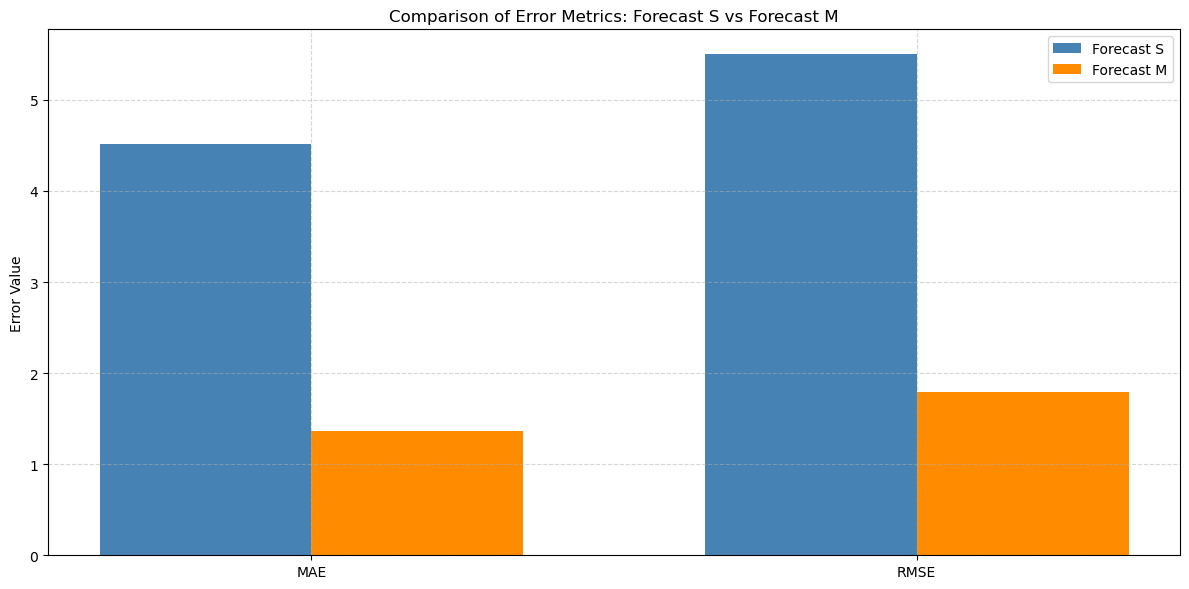

In [44]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [45]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,4.52,1.37
RMSE,5.50,1.80


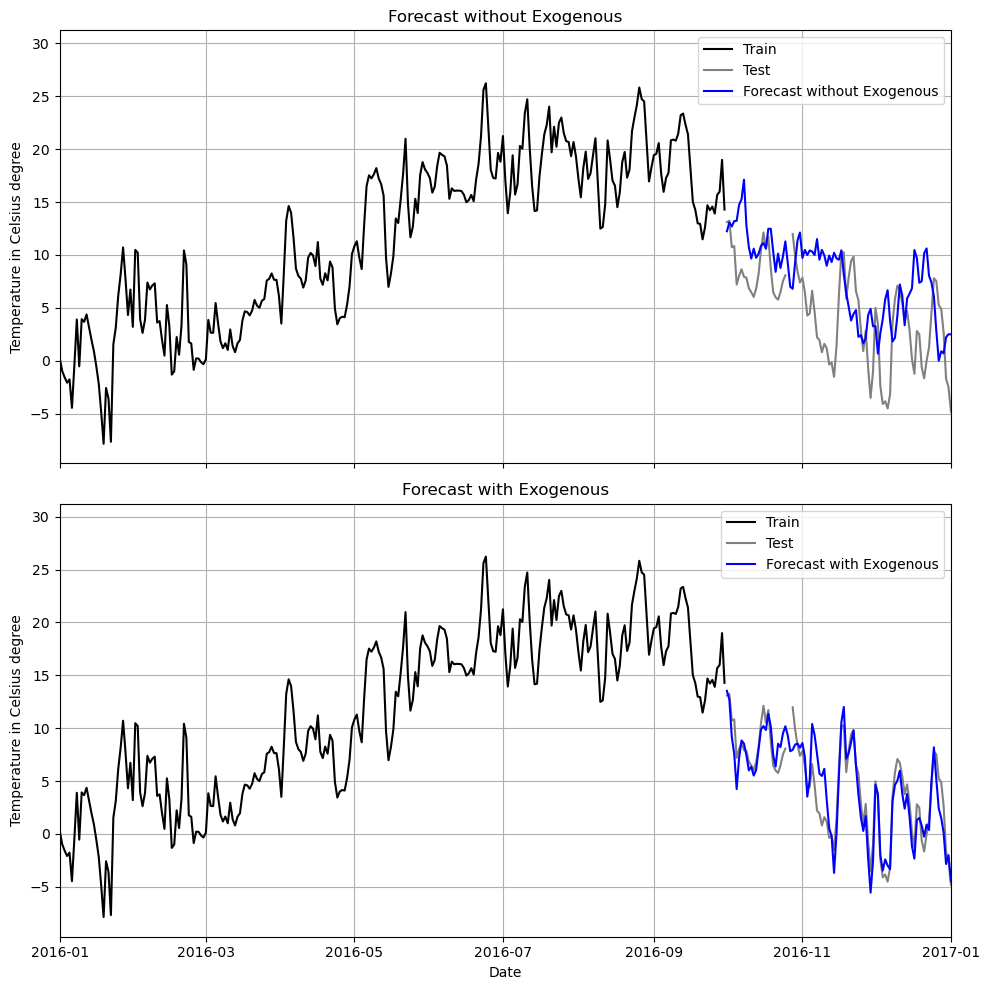

In [46]:
# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# --- First Forecast (Forecast S) ---
#axes[0].fill_between(test.index,
#                     conf_int_S.iloc[:, 0],
#                     conf_int_S.iloc[:, 1],
#                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].plot(train.index, train['T (degC)'], label='Train', color='black')
axes[0].plot(test.index, test['T (degC)'], label='Test', color='gray')
axes[0].plot(test.index, test['Forecast S'], label='Forecast without Exogenous', color='blue')

axes[0].set_title('Forecast without Exogenous')
axes[0].set_ylabel('Temperature in Celsius degree')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2017-01-01'))
#axes[0].set_ylim(0, 60)

# --- Second Forecast (Forecast M) ---
#axes[1].fill_between(test.index,
#                     conf_int_M.iloc[:, 0],
#                     conf_int_M.iloc[:, 1],
#                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[1].plot(train.index, train['T (degC)'], label='Train', color='black')
axes[1].plot(test.index, test['T (degC)'], label='Test', color='gray')
axes[1].plot(test.index, test['Forecast M'], label='Forecast with Exogenous', color='blue')

axes[1].set_title('Forecast with Exogenous')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Temperature in Celsius degree')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2017-01-01'))
#axes[1].set_ylim(0, 60)

# Final layout
plt.tight_layout()
plt.show()

End.